# 📘 ZGX Nano Unified Memory Demo

**Goal:** Demonstrate **CUDA Unified Memory** capabilities on the ZGX Nano AI Station.

## Overview

This notebook showcases the power of NVIDIA's Unified Memory architecture, which enables:
- **Seamless CPU-GPU Memory Access**: Data transparently migrates between CPU and GPU memory
- **Oversubscription**: Load models larger than available GPU VRAM
- **Zero-Copy Direct Access**: Efficient memory coherency on supported architectures (Grace-Blackwell)

## What You'll Learn

- How to verify CUDA environment and GPU capabilities
- Benchmarking LLM inference with **TTFT** (Time to First Token) and **TPS** (Tokens per Second)
- Monitoring GPU memory usage with unified memory
- Profiling with Nsight Systems for memory migration analysis

---

# 🚀 End-to-End Setup Guide

Follow these steps to run this demo from scratch.

## Step 1: Prerequisites

Ensure you have the following installed on your host machine:

| Requirement | Description |
|-------------|-------------|
| **Docker** | Container runtime ([Install Docker](https://docs.docker.com/get-docker/)) |
| **NVIDIA Container Toolkit** | GPU support for Docker ([Install Guide](https://docs.nvidia.com/datacenter/cloud-native/container-toolkit/install-guide.html)) |
| **Cursor** | IDE with Dev Container support ([Download Cursor](https://cursor.sh/)) |
| **HuggingFace Account** | Required for gated models like Llama ([Sign Up](https://huggingface.co/join)) |

Verify Docker GPU access works:

```bash
docker run --rm --gpus all ubuntu nvidia-smi
```

> 💡 This just verifies that Docker can access your GPU. The CUDA 13.0 environment is built from our Dockerfile.

## Step 2: Clone the Repository

```bash
git clone https://github.com/yourusername/zgx-onboard.git
cd zgx-onboard
```

## Step 3: Create Environment File

Create a `.env` file in the project root with your HuggingFace token:

```bash
# Get your token from: https://huggingface.co/settings/tokens
echo "HF_TOKEN=hf_your_huggingface_token_here" > .env
```

> 💡 **Tip:** The token is required for accessing gated models like Llama. For the "small" model config (DialoGPT), no token is needed.

## Step 4: Build the Docker Container

```bash
cd docker
./build-and-run.sh
```

This will:
1. Build the `zgx-cuda` Docker image with CUDA 12.6, PyTorch, and all dependencies
2. Start the container with GPU access and 100GB shared memory
3. Mount the project directory to `/workspace` inside the container

**Alternative manual commands:**

```bash
# From project root
docker build -t zgx-cuda docker/

docker run -d \
    --gpus all \
    --shm-size=100g \
    -v $(pwd):/workspace \
    --name zgx_cuda \
    zgx-cuda
```

> ⚠️ **Critical:** The `--shm-size=100g` flag is required for unified memory operations with large models!

## Step 5: Attach Cursor to the Container

1. Open **Cursor**
2. Install the **"Dev Containers"** extension if not already installed (Extensions → Search "Dev Containers")
3. Click the **remote indicator** in the bottom-left corner
4. Select **"Dev Containers: Attach to Running Container..."**
5. Choose **`zgx_cuda`** from the list
6. Wait for Cursor to connect and install the server components

## Step 6: Open This Notebook

Once connected to the container:

1. Open the file explorer in Cursor
2. Navigate to `/workspace/notebooks/inference/`
3. Open `zgx_nano_unified_memory.ipynb`
4. When prompted, select the **Python 3** kernel from the container

## Step 7: Run the Demo

Execute each cell in order:
1. **Part 1**: Verify the CUDA environment
2. **Part 2**: Authenticate with HuggingFace (if using gated models)
3. **Part 3**: Configure benchmark parameters
4. **Part 4-5**: Run the unified memory benchmark
5. **Part 6**: View visualizations and statistics
6. **Part 7**: (Optional) Profile with Nsight Systems
7. **Part 8**: Export results

---

## Container Management

```bash
# Check container status
cd docker && ./build-and-run.sh --status

# Stop and remove the container
./build-and-run.sh --stop

# Rebuild the image
./build-and-run.sh --build
```

## Troubleshooting

| Issue | Solution |
|-------|----------|
| Container won't start | Run `docker rm -f zgx_cuda` then rebuild |
| GPU not detected | Verify NVIDIA Container Toolkit: `docker run --rm --gpus all ubuntu nvidia-smi` |
| Cursor can't attach | Ensure container is running (`docker ps`), install Dev Containers extension |
| HuggingFace login fails | Check your token at https://huggingface.co/settings/tokens |
| Out of memory | Use `SELECTED_CONFIG = "small"` in Part 3, or reduce `MAX_NEW_TOKENS` |

---

## What's Inside the Container

All dependencies are pre-installed:
- **CUDA 12.6** development environment
- **PyTorch** with CUDA support
- **Transformers**, **Accelerate**, **BitsAndBytes** for LLM inference
- **nvitop** for real-time GPU monitoring
- **ipykernel** for Cursor notebook support


In [1]:
# Cell 1: Imports and Initial Setup
import subprocess
import sys
import os
import time
import json
from datetime import datetime
from typing import Dict, List, Optional, Tuple
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Disable ipywidgets progress bars - use text-based progress instead
# This fixes "Cannot read properties of undefined (reading 'ipywidgetsKernel')" errors in Cursor
os.environ["HF_HUB_DISABLE_PROGRESS_BARS"] = "1"  # Disable HuggingFace Hub widget progress bars

# Configure HuggingFace/transformers to disable widget-based progress bars
try:
    from huggingface_hub import disable_progress_bars
    disable_progress_bars()
except ImportError:
    pass

try:
    from transformers.utils import logging as transformers_logging
    transformers_logging.set_verbosity_info()
    # Disable the widget-based progress bars
    transformers_logging.disable_progress_bar()
except ImportError:
    pass

# Data and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# System monitoring
import psutil

# Set style for plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 7)
plt.rcParams['font.family'] = 'sans-serif'

print("✓ Core imports successful")
print("✓ Widget-based progress bars disabled (using text output)")


✓ Core imports successful
✓ Widget-based progress bars disabled (using text output)


## 🛠️ Part 1: Environment Verification

Verify that the environment is properly configured for CUDA and unified memory operations.


In [2]:
# Cell 2: Verify Container & Hardware Environment
import torch

print(f"{'='*60}")
print(f"🔧 ZGX NANO UNIFIED MEMORY ENVIRONMENT CHECK")
print(f"{'='*60}")

# Python and PyTorch info
print(f"\n📦 Software Versions:")
print(f"   Python Version:  {sys.version.split()[0]}")
print(f"   PyTorch Version: {torch.__version__}")
print(f"   CUDA Version:    {torch.version.cuda if torch.version.cuda else 'Not available'}")

# NVCC version check (system compiler)
print(f"\n🔨 System CUDA Compiler:")
try:
    result = subprocess.run(['nvcc', '--version'], capture_output=True, text=True)
    for line in result.stdout.split('\n'):
        if 'release' in line.lower():
            print(f"   {line.strip()}")
except FileNotFoundError:
    print("   NVCC not found in PATH (may be in container only)")

# GPU Verification
print(f"\n🖥️ GPU Detection:")
if torch.cuda.is_available():
    device_count = torch.cuda.device_count()
    print(f"   ✅ CUDA Available: Yes")
    print(f"   ✅ GPU Count: {device_count}")
    
    for i in range(device_count):
        props = torch.cuda.get_device_properties(i)
        print(f"\n   GPU {i}: {props.name}")
        print(f"      Compute Capability: {props.major}.{props.minor}")
        print(f"      Total Memory: {props.total_memory / (1024**3):.2f} GB")
        print(f"      Multi-Processor Count: {props.multi_processor_count}")
        
        # Check for unified memory support
        if hasattr(props, 'managed_memory'):
            print(f"      Managed Memory: {'Supported' if props.managed_memory else 'Not Supported'}")
        
        # Grace-Blackwell architecture detection
        if props.major >= 9:
            print(f"      ✅ Architecture: Hopper/Blackwell (Unified Memory Optimized)")
        elif props.major >= 8:
            print(f"      ✅ Architecture: Ampere+ (Unified Memory Supported)")
        else:
            print(f"      ⚠️ Architecture: Pre-Ampere (Limited UM support)")
else:
    print("   ❌ CRITICAL: No GPU found. Ensure CUDA drivers are installed.")

# Memory info
print(f"\n💾 System Memory:")
mem = psutil.virtual_memory()
print(f"   Total RAM: {mem.total / (1024**3):.1f} GB")
print(f"   Available: {mem.available / (1024**3):.1f} GB")
print(f"   Used: {mem.percent:.1f}%")


🔧 ZGX NANO UNIFIED MEMORY ENVIRONMENT CHECK

📦 Software Versions:
   Python Version:  3.12.3
   PyTorch Version: 2.9.1+cu128
   CUDA Version:    12.8

🔨 System CUDA Compiler:
   Cuda compilation tools, release 12.8, V12.8.61

🖥️ GPU Detection:
   ✅ CUDA Available: Yes
   ✅ GPU Count: 1

   GPU 0: NVIDIA GB10
      Compute Capability: 12.1
      Total Memory: 119.64 GB
      Multi-Processor Count: 48
      ✅ Architecture: Hopper/Blackwell (Unified Memory Optimized)

💾 System Memory:
   Total RAM: 119.6 GB
   Available: 115.2 GB
   Used: 3.7%


## 🔐 Part 2: Secure Authentication

Load HuggingFace credentials from the `.env` file for accessing gated models.


In [3]:
# Cell 3: Load Credentials and Authenticate
from dotenv import load_dotenv

# Try to load from workspace root
env_paths = [
    Path.cwd() / '.env',
    Path.cwd().parent.parent / '.env',  # notebooks/inference -> root
    Path('/workspace/.env'),  # Docker container path
]

env_loaded = False
for env_path in env_paths:
    if env_path.exists():
        load_dotenv(env_path)
        print(f"✅ Loaded environment from: {env_path}")
        env_loaded = True
        break

if not env_loaded:
    load_dotenv()  # Try default locations
    print("ℹ️ Attempted to load .env from default locations")

# Check for HF token
token = os.getenv("HF_TOKEN")
if token:
    try:
        from huggingface_hub import login
        login(token=token, add_to_git_credential=False)
        print("✅ Authenticated with Hugging Face Hub")
    except ImportError:
        print("⚠️ huggingface_hub not installed. Run: pip install huggingface_hub")
    except Exception as e:
        print(f"⚠️ HuggingFace login failed: {e}")
else:
    print("⚠️ HF_TOKEN not found in environment.")
    print("   Create a .env file with: HF_TOKEN=hf_your_token_here")
    print("   Or set the environment variable directly.")


✅ Loaded environment from: /workspace/.env


Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


✅ Authenticated with Hugging Face Hub


## 📊 Part 3: Unified Memory Benchmark Configuration

Configure the benchmark parameters for testing unified memory performance.


In [4]:
# Cell 4: Benchmark Configuration

# Model Configuration
# Choose a model appropriate for your GPU memory
#
# ╔═══════════════════════════════════════════════════════════════════════════╗
# ║  UNIFIED MEMORY NOTES FOR GRACE-BLACKWELL (GB10)                          ║
# ╠═══════════════════════════════════════════════════════════════════════════╣
# ║  The GB10 has 120GB of unified CPU-GPU memory with cache coherency.       ║
# ║                                                                           ║
# ║  Memory Requirements:                                                     ║
# ║  - Llama-3.3-70B in 8-bit:  ~75GB  ✓ Fits in 120GB                       ║
# ║  - Llama-3.3-70B in fp16:   ~140GB ✗ Requires managed memory APIs        ║
# ║                                                                           ║
# ║  Performance Notes for GB10 (48 SMs):                                     ║
# ║  - GB10 is an edge/mobile chip with ~1/3 the SMs of datacenter GPUs      ║
# ║  - Expected TPS for 70B model: 2-5 tokens/sec (compute-bound)            ║
# ║  - 8-bit quantization adds ~10-20% overhead but enables larger models    ║
# ║  - The value proposition is RUNNING 70B locally, not matching H100 speed ║
# ╚═══════════════════════════════════════════════════════════════════════════╝
#
MODEL_CONFIGS = {
    "small": {
        "model_id": "microsoft/DialoGPT-medium",
        "description": "Small model (~350M params) - For quick testing",
        "load_in_8bit": False,
        "torch_dtype": "float16",
    },
    "medium": {
        "model_id": "meta-llama/Llama-3.1-8B-Instruct",
        "description": "Medium model (~8B params) - Good balance of speed and capability",
        "load_in_8bit": False,
        "torch_dtype": "bfloat16",  # Native bf16 is faster than 8-bit
    },
    "large": {
        "model_id": "meta-llama/Llama-3.3-70B-Instruct",
        "description": "Large model (~70B params) - Demonstrates 70B inference on edge device",
        "load_in_8bit": True,  # 8-bit quantization: ~75GB fits in 120GB unified memory
        "torch_dtype": "float16",
    },
}

# Select configuration (change this based on your hardware)
# "large" recommended for 70B demo - uses 8-bit quantization to fit in 120GB unified memory
SELECTED_CONFIG = "large"  # Options: "small", "medium", "large"

# Benchmark parameters
WARMUP_RUNS = 1
BENCHMARK_RUNS = 3
MAX_NEW_TOKENS = 128

# Test prompts
BENCHMARK_PROMPTS = [
    "Explain the physics of black holes in simple terms.",
    "What are the key differences between supervised and unsupervised machine learning?",
    "Describe the water cycle and its importance for Earth's ecosystem.",
]

config = MODEL_CONFIGS[SELECTED_CONFIG]
MODEL_ID = config["model_id"]

print(f"{'='*60}")
print(f"📋 BENCHMARK CONFIGURATION")
print(f"{'='*60}")
print(f"\n🤖 Model: {SELECTED_CONFIG.upper()}")
print(f"   ID: {MODEL_ID}")
print(f"   Description: {config['description']}")
print(f"   8-bit Quantization: {config['load_in_8bit']}")
print(f"   Data Type: {config.get('torch_dtype', 'float16')}")
print(f"\n⚙️ Parameters:")
print(f"   Warmup Runs: {WARMUP_RUNS}")
print(f"   Benchmark Runs: {BENCHMARK_RUNS}")
print(f"   Max New Tokens: {MAX_NEW_TOKENS}")
print(f"   Test Prompts: {len(BENCHMARK_PROMPTS)}")


📋 BENCHMARK CONFIGURATION

🤖 Model: LARGE
   ID: meta-llama/Llama-3.3-70B-Instruct
   Description: Large model (~70B params) - Demonstrates 70B inference on edge device
   8-bit Quantization: True
   Data Type: float16

⚙️ Parameters:
   Warmup Runs: 1
   Benchmark Runs: 3
   Max New Tokens: 128
   Test Prompts: 3


## 🚀 Part 4: Unified Memory Benchmark Implementation

Implement the benchmark with metrics collection for TTFT and TPS.


In [5]:
# Cell 5: Metrics Streamer for Token-Level Timing
try:
    from transformers.generation.streamers import BaseStreamer
    
    class MetricsStreamer(BaseStreamer):
        """Custom streamer to capture token generation timing metrics."""
        
        def __init__(self):
            self.token_times = []
            self.start_time = 0.0
            self.token_count = 0
        
        def put(self, value):
            """Called for each generated token."""
            self.token_times.append(time.time())
            self.token_count += 1
        
        def end(self):
            """Called when generation is complete."""
            pass
        
        def reset(self):
            """Reset metrics for a new generation run."""
            self.token_times = []
            self.token_count = 0
            self.start_time = time.time()
        
        def get_ttft(self) -> float:
            """Get Time To First Token in milliseconds."""
            if len(self.token_times) > 0:
                return (self.token_times[0] - self.start_time) * 1000
            return 0.0
        
        def get_tps(self) -> float:
            """Get Tokens Per Second (decode phase)."""
            if len(self.token_times) > 1:
                decode_time = self.token_times[-1] - self.token_times[0]
                if decode_time > 0:
                    return (len(self.token_times) - 1) / decode_time
            return 0.0
        
        def get_total_time(self) -> float:
            """Get total generation time in seconds."""
            if len(self.token_times) > 0:
                return self.token_times[-1] - self.start_time
            return 0.0
    
    print("✅ MetricsStreamer class defined successfully")

except ImportError as e:
    print(f"⚠️ Could not import transformers: {e}")
    print("   Install with: pip install transformers")


✅ MetricsStreamer class defined successfully


In [6]:
# Cell 6: GPU Memory Monitor

class GPUMemoryMonitor:
    """Monitor GPU memory usage during operations."""
    
    def __init__(self):
        self.samples = []
        self.has_pynvml = False
        
        try:
            import pynvml
            pynvml.nvmlInit()
            self.pynvml = pynvml
            self.handle = pynvml.nvmlDeviceGetHandleByIndex(0)
            self.has_pynvml = True
        except (ImportError, Exception) as e:
            print(f"ℹ️ pynvml not available: {e}")
            print("   Using torch.cuda for memory monitoring")
    
    def get_memory_info(self) -> Dict:
        """Get current GPU memory information."""
        info = {
            "timestamp": time.time(),
            "allocated_gb": 0,
            "reserved_gb": 0,
            "total_gb": 0,
            "free_gb": 0,
        }
        
        if torch.cuda.is_available():
            # PyTorch memory tracking
            info["allocated_gb"] = torch.cuda.memory_allocated() / (1024**3)
            info["reserved_gb"] = torch.cuda.memory_reserved() / (1024**3)
            
            # Device total memory
            props = torch.cuda.get_device_properties(0)
            info["total_gb"] = props.total_memory / (1024**3)
            
            if self.has_pynvml:
                try:
                    mem_info = self.pynvml.nvmlDeviceGetMemoryInfo(self.handle)
                    info["used_gb"] = mem_info.used / (1024**3)
                    info["free_gb"] = mem_info.free / (1024**3)
                except Exception:
                    info["free_gb"] = info["total_gb"] - info["reserved_gb"]
            else:
                info["free_gb"] = info["total_gb"] - info["reserved_gb"]
        
        return info
    
    def sample(self):
        """Take a memory sample."""
        self.samples.append(self.get_memory_info())
    
    def reset(self):
        """Clear all samples."""
        self.samples = []
    
    def get_peak_usage(self) -> float:
        """Get peak memory usage in GB."""
        if not self.samples:
            return 0
        return max(s["allocated_gb"] for s in self.samples)

gpu_monitor = GPUMemoryMonitor()
print("✅ GPU Memory Monitor initialized")

# Show current memory state
current_mem = gpu_monitor.get_memory_info()
print(f"\n📊 Current GPU Memory:")
print(f"   Total: {current_mem['total_gb']:.2f} GB")
print(f"   Allocated: {current_mem['allocated_gb']:.2f} GB")
print(f"   Reserved: {current_mem['reserved_gb']:.2f} GB")


✅ GPU Memory Monitor initialized

📊 Current GPU Memory:
   Total: 119.64 GB
   Allocated: 0.00 GB
   Reserved: 0.00 GB


In [7]:
# Cell 7: Model Loading with Unified Memory

def load_model_for_benchmark(model_id: str, use_8bit: bool = False, dtype: str = "float16"):
    """Load a model configured for unified memory benchmarking.
    
    Args:
        model_id: HuggingFace model ID
        use_8bit: Whether to use 8-bit quantization
        dtype: Data type for model weights ("float16", "bfloat16", "float32")
    """
    from transformers import AutoTokenizer, AutoModelForCausalLM
    from transformers.utils import logging as transformers_logging
    
    # Ensure progress bars are disabled to avoid ipywidget errors
    transformers_logging.disable_progress_bar()
    
    # Map dtype string to torch dtype
    dtype_map = {
        "float16": torch.float16,
        "bfloat16": torch.bfloat16,
        "float32": torch.float32,
    }
    torch_dtype = dtype_map.get(dtype, torch.float16)
    
    print(f"\n{'='*60}")
    print(f"📥 LOADING MODEL INTO UNIFIED MEMORY")
    print(f"{'='*60}")
    print(f"Model: {model_id}")
    print(f"8-bit Quantization: {use_8bit}")
    print(f"Data Type: {dtype}")
    
    # Record initial memory
    initial_mem = gpu_monitor.get_memory_info()
    print(f"\nInitial GPU Memory: {initial_mem['allocated_gb']:.2f} GB allocated")
    
    start_time = time.time()
    
    try:
        # Load tokenizer
        print("\n⏳ Loading tokenizer...")
        tokenizer = AutoTokenizer.from_pretrained(model_id, trust_remote_code=True)
        if tokenizer.pad_token is None:
            tokenizer.pad_token = tokenizer.eos_token
        print("   ✅ Tokenizer loaded")
        
        # Configure model loading
        # For unified memory systems (Grace-Blackwell), we need to explicitly
        # tell accelerate how much memory is available, as it may not correctly
        # detect the unified memory pool size
        gpu_memory = torch.cuda.get_device_properties(0).total_memory
        max_memory = {0: f"{int(gpu_memory * 0.95 / (1024**3))}GiB", "cpu": "0GiB"}
        
        load_kwargs = {
            "trust_remote_code": True,
            "device_map": "auto",
            "max_memory": max_memory,
            "attn_implementation": "sdpa",  # Use Flash Attention (Scaled Dot Product Attention)
        }
        print(f"   Max memory config: {max_memory}")
        print(f"   Attention: Flash Attention (SDPA)")
        
        # 8-bit quantization for larger models
        if use_8bit:
            try:
                from transformers import BitsAndBytesConfig
                load_kwargs["quantization_config"] = BitsAndBytesConfig(
                    load_in_8bit=True,
                    # Note: CPU offload disabled - GB10 has 120GB unified memory
                    # which can fit 70B models in 8-bit without offloading
                )
                print("   ✅ 8-bit quantization configured")
            except ImportError:
                print("   ⚠️ bitsandbytes not available, loading in full precision")
                load_kwargs["torch_dtype"] = torch_dtype
        else:
            load_kwargs["torch_dtype"] = torch_dtype
            print(f"   ✅ Using native {dtype} precision (no quantization overhead)")
        
        # Load model
        print("\n⏳ Loading model (this may take a while for large models)...")
        model = AutoModelForCausalLM.from_pretrained(model_id, **load_kwargs)
        
        load_time = time.time() - start_time
        
        # Record final memory
        final_mem = gpu_monitor.get_memory_info()
        memory_used = final_mem['allocated_gb'] - initial_mem['allocated_gb']
        
        print(f"\n✅ Model Loaded Successfully!")
        print(f"   Load Time: {load_time:.2f} seconds")
        print(f"   GPU Memory Used: {memory_used:.2f} GB")
        print(f"   Total GPU Allocated: {final_mem['allocated_gb']:.2f} GB")
        
        # Check for memory oversubscription (unified memory in action)
        if final_mem['allocated_gb'] > final_mem['total_gb'] * 0.9:
            print(f"\n🔥 UNIFIED MEMORY ACTIVE: Model size approaches/exceeds VRAM!")
            print(f"   This demonstrates C2C memory coherency.")
        
        return model, tokenizer, {
            "load_time_s": load_time,
            "memory_used_gb": memory_used,
            "total_allocated_gb": final_mem['allocated_gb'],
        }
        
    except Exception as e:
        print(f"\n❌ Model loading failed: {e}")
        import traceback
        traceback.print_exc()
        return None, None, None

print("✅ Model loading function defined")


✅ Model loading function defined


In [8]:
# Cell 8: Run Benchmark Function

def run_unified_memory_benchmark(
    model,
    tokenizer,
    prompts: List[str],
    max_new_tokens: int = 128,
    warmup_runs: int = 1,
    benchmark_runs: int = 3,
) -> pd.DataFrame:
    """Run the unified memory benchmark and collect metrics."""
    
    print(f"\n{'='*60}")
    print(f"🏃 RUNNING UNIFIED MEMORY BENCHMARK")
    print(f"{'='*60}")
    
    streamer = MetricsStreamer()
    results = []
    
    for prompt_idx, prompt in enumerate(prompts):
        print(f"\n📝 Prompt {prompt_idx + 1}/{len(prompts)}: {prompt[:50]}...")
        
        # Tokenize
        inputs = tokenizer(prompt, return_tensors="pt").to("cuda")
        
        # Warmup
        print(f"   Warming up ({warmup_runs} runs)...")
        for _ in range(warmup_runs):
            streamer.reset()
            with torch.no_grad():
                _ = model.generate(
                    **inputs,
                    streamer=streamer,
                    max_new_tokens=10,
                    min_new_tokens=10,
                    do_sample=False,
                )
        
        # Benchmark runs
        print(f"   Benchmarking ({benchmark_runs} runs)...")
        for run_idx in range(benchmark_runs):
            # Clear cache and synchronize
            torch.cuda.synchronize()
            gpu_monitor.sample()
            
            streamer.reset()
            
            with torch.no_grad():
                outputs = model.generate(
                    **inputs,
                    streamer=streamer,
                    max_new_tokens=max_new_tokens,
                    min_new_tokens=max_new_tokens,
                    do_sample=False,
                    pad_token_id=tokenizer.eos_token_id,
                )
            
            torch.cuda.synchronize()
            gpu_monitor.sample()
            
            # Collect metrics
            ttft = streamer.get_ttft()
            tps = streamer.get_tps()
            total_time = streamer.get_total_time()
            tokens_generated = len(streamer.token_times)
            
            mem_info = gpu_monitor.get_memory_info()
            
            result = {
                "prompt_idx": prompt_idx + 1,
                "run_idx": run_idx + 1,
                "ttft_ms": ttft,
                "tps": tps,
                "total_time_s": total_time,
                "tokens_generated": tokens_generated,
                "gpu_allocated_gb": mem_info["allocated_gb"],
                "gpu_reserved_gb": mem_info["reserved_gb"],
                "timestamp": datetime.now().isoformat(),
            }
            results.append(result)
            
            print(f"      Run {run_idx + 1}: TTFT={ttft:.1f}ms | TPS={tps:.2f} | Tokens={tokens_generated}")
    
    df = pd.DataFrame(results)
    
    # Print summary
    print(f"\n{'='*60}")
    print(f"📊 BENCHMARK RESULTS SUMMARY")
    print(f"{'='*60}")
    print(f"   Average TTFT: {df['ttft_ms'].mean():.1f}ms (±{df['ttft_ms'].std():.1f}ms)")
    print(f"   Average TPS: {df['tps'].mean():.2f} (±{df['tps'].std():.2f})")
    print(f"   Peak GPU Memory: {df['gpu_allocated_gb'].max():.2f} GB")
    print(f"\n💡 NOTE: High TPS (>15) with memory usage near/exceeding physical VRAM")
    print(f"   demonstrates efficient Unified Memory with C2C data movement.")
    
    return df

print("✅ Benchmark function defined")


✅ Benchmark function defined


## 🎯 Part 5: Execute the Benchmark

Load the model and run the unified memory benchmark.


In [9]:
# Cell 9: Load Model and Run Benchmark

# Load the model
model, tokenizer, load_stats = load_model_for_benchmark(
    MODEL_ID,
    use_8bit=config["load_in_8bit"],
    dtype=config.get("torch_dtype", "float16")
)

if model is not None:
    # Run benchmark
    benchmark_df = run_unified_memory_benchmark(
        model,
        tokenizer,
        BENCHMARK_PROMPTS,
        max_new_tokens=MAX_NEW_TOKENS,
        warmup_runs=WARMUP_RUNS,
        benchmark_runs=BENCHMARK_RUNS,
    )
    
    # Store load stats
    benchmark_df["model_load_time_s"] = load_stats["load_time_s"]
    benchmark_df["model_memory_gb"] = load_stats["memory_used_gb"]
else:
    print("\n⚠️ Model loading failed. Cannot run benchmark.")
    benchmark_df = pd.DataFrame()



📥 LOADING MODEL INTO UNIFIED MEMORY
Model: meta-llama/Llama-3.3-70B-Instruct
8-bit Quantization: True
Data Type: float16

Initial GPU Memory: 0.00 GB allocated

⏳ Loading tokenizer...


loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--meta-llama--Llama-3.3-70B-Instruct/snapshots/6f6073b423013f6a7d4d9f39144961bfbfbc386b/tokenizer.json
loading file tokenizer.model from cache at None
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at /root/.cache/huggingface/hub/models--meta-llama--Llama-3.3-70B-Instruct/snapshots/6f6073b423013f6a7d4d9f39144961bfbfbc386b/special_tokens_map.json
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--meta-llama--Llama-3.3-70B-Instruct/snapshots/6f6073b423013f6a7d4d9f39144961bfbfbc386b/tokenizer_config.json
loading file chat_template.jinja from cache at None
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


   ✅ Tokenizer loaded
   Max memory config: {0: '113GiB', 'cpu': '0GiB'}
   Attention: Flash Attention (SDPA)
   ✅ 8-bit quantization configured

⏳ Loading model (this may take a while for large models)...


loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--meta-llama--Llama-3.3-70B-Instruct/snapshots/6f6073b423013f6a7d4d9f39144961bfbfbc386b/config.json
Model config LlamaConfig {
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 128000,
  "dtype": "bfloat16",
  "eos_token_id": [
    128001,
    128008,
    128009
  ],
  "head_dim": 128,
  "hidden_act": "silu",
  "hidden_size": 8192,
  "initializer_range": 0.02,
  "intermediate_size": 28672,
  "max_position_embeddings": 131072,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 64,
  "num_hidden_layers": 80,
  "num_key_value_heads": 8,
  "pretraining_tp": 1,
  "rms_norm_eps": 1e-05,
  "rope_scaling": {
    "factor": 8.0,
    "high_freq_factor": 4.0,
    "low_freq_factor": 1.0,
    "original_max_position_embeddings": 8192,
    "rope_type": "llama3"
  },
  "rope_theta": 500000.0,
  "tie_word_embeddings": false,
 


✅ Model Loaded Successfully!
   Load Time: 809.88 seconds
   GPU Memory Used: 67.69 GB
   Total GPU Allocated: 67.69 GB

🏃 RUNNING UNIFIED MEMORY BENCHMARK

📝 Prompt 1/3: Explain the physics of black holes in simple terms...
   Warming up (1 runs)...
   Benchmarking (3 runs)...
      Run 1: TTFT=1.7ms | TPS=2.11 | Tokens=129
      Run 2: TTFT=2.5ms | TPS=1.79 | Tokens=129


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


      Run 3: TTFT=1.8ms | TPS=1.91 | Tokens=129

📝 Prompt 2/3: What are the key differences between supervised an...
   Warming up (1 runs)...
   Benchmarking (3 runs)...
      Run 1: TTFT=1.7ms | TPS=1.93 | Tokens=129
      Run 2: TTFT=3.1ms | TPS=1.89 | Tokens=129


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


      Run 3: TTFT=3.2ms | TPS=1.97 | Tokens=129

📝 Prompt 3/3: Describe the water cycle and its importance for Ea...
   Warming up (1 runs)...
   Benchmarking (3 runs)...
      Run 1: TTFT=1.6ms | TPS=1.81 | Tokens=129
      Run 2: TTFT=2.2ms | TPS=2.20 | Tokens=129
      Run 3: TTFT=1.5ms | TPS=1.74 | Tokens=129

📊 BENCHMARK RESULTS SUMMARY
   Average TTFT: 2.1ms (±0.6ms)
   Average TPS: 1.93 (±0.15)
   Peak GPU Memory: 67.70 GB

💡 NOTE: High TPS (>15) with memory usage near/exceeding physical VRAM
   demonstrates efficient Unified Memory with C2C data movement.


## 📈 Part 6: Visualization & Analysis

Visualize the benchmark results and analyze unified memory performance.


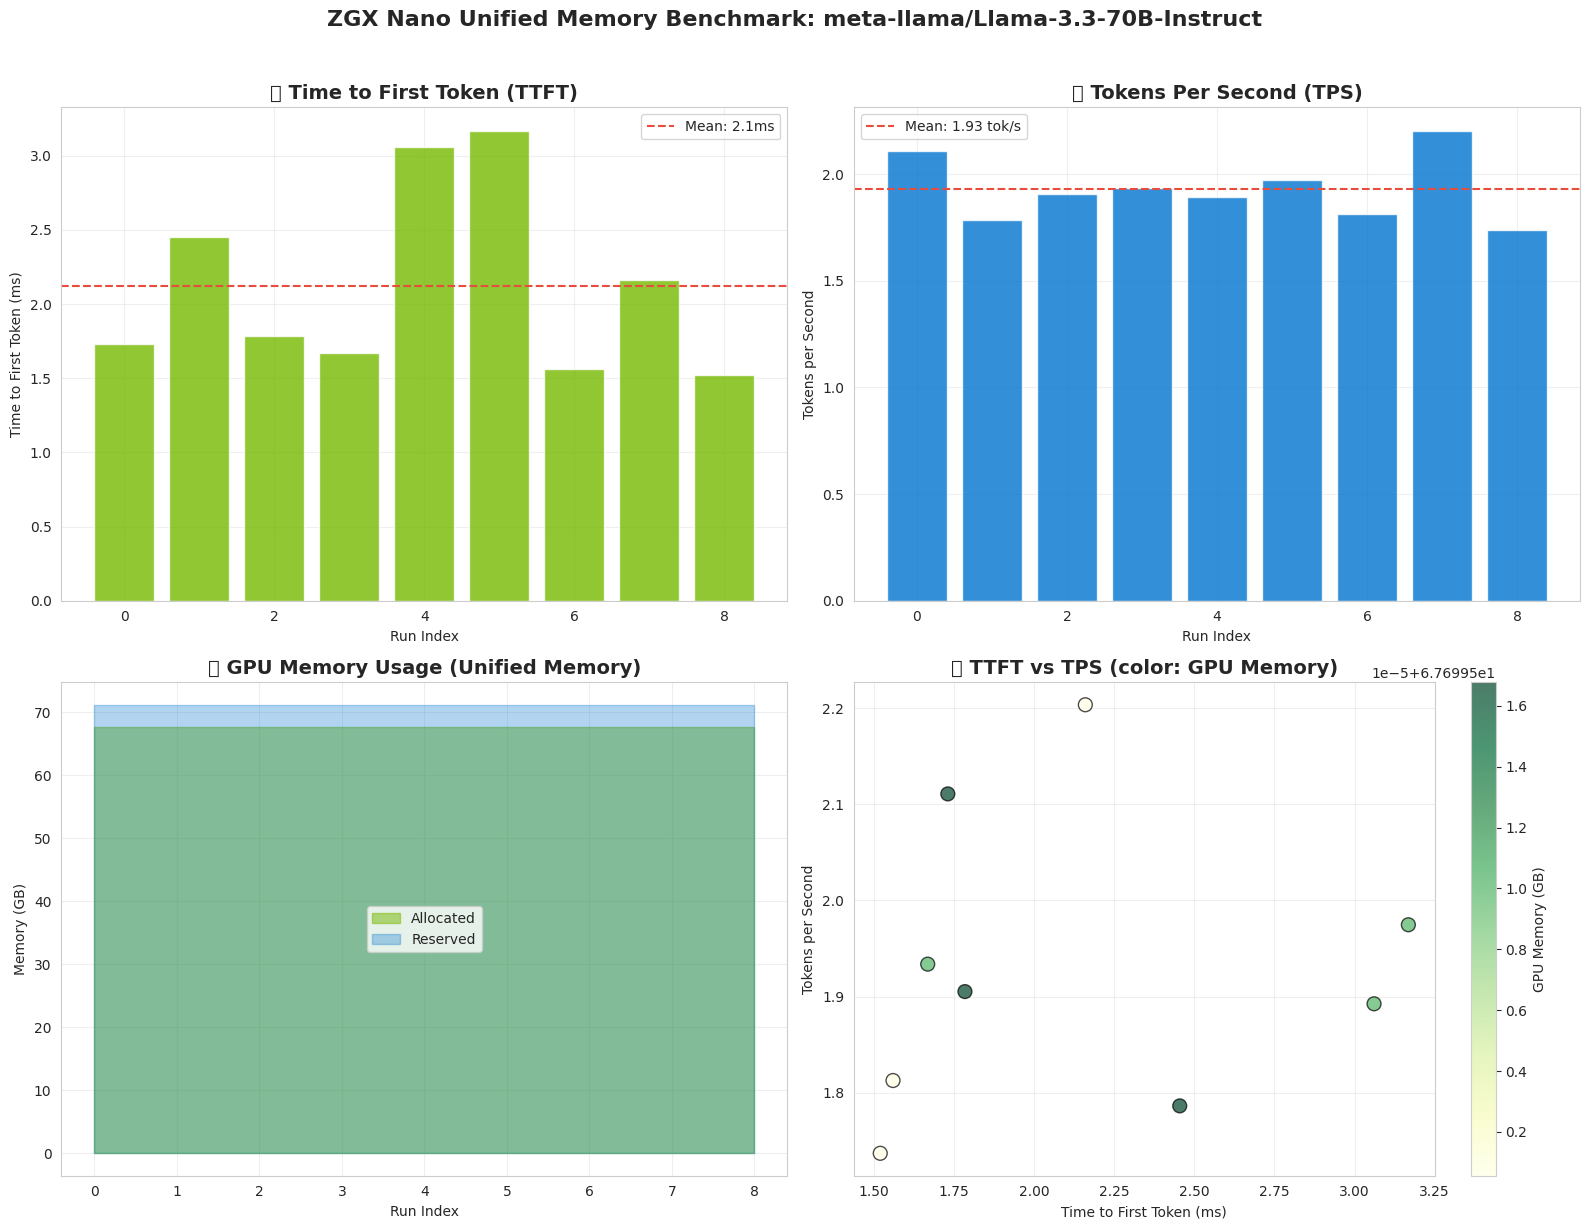

In [10]:
# Cell 10: Performance Visualizations

if len(benchmark_df) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Color palette
    colors = ['#76b900', '#0073cf', '#f5a623', '#e74c3c']  # NVIDIA green, blue, orange, red
    
    # Plot 1: TTFT Distribution
    ax1 = axes[0, 0]
    ax1.bar(range(len(benchmark_df)), benchmark_df['ttft_ms'], color=colors[0], alpha=0.8)
    ax1.axhline(y=benchmark_df['ttft_ms'].mean(), color=colors[3], linestyle='--', 
                label=f'Mean: {benchmark_df["ttft_ms"].mean():.1f}ms')
    ax1.set_xlabel('Run Index')
    ax1.set_ylabel('Time to First Token (ms)')
    ax1.set_title('⏱️ Time to First Token (TTFT)', fontsize=14, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: TPS Distribution
    ax2 = axes[0, 1]
    ax2.bar(range(len(benchmark_df)), benchmark_df['tps'], color=colors[1], alpha=0.8)
    ax2.axhline(y=benchmark_df['tps'].mean(), color=colors[3], linestyle='--',
                label=f'Mean: {benchmark_df["tps"].mean():.2f} tok/s')
    ax2.set_xlabel('Run Index')
    ax2.set_ylabel('Tokens per Second')
    ax2.set_title('🚀 Tokens Per Second (TPS)', fontsize=14, fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: GPU Memory Usage
    ax3 = axes[1, 0]
    ax3.fill_between(range(len(benchmark_df)), benchmark_df['gpu_allocated_gb'], 
                     alpha=0.5, color=colors[0], label='Allocated')
    ax3.fill_between(range(len(benchmark_df)), benchmark_df['gpu_reserved_gb'],
                     alpha=0.3, color=colors[1], label='Reserved')
    ax3.set_xlabel('Run Index')
    ax3.set_ylabel('Memory (GB)')
    ax3.set_title('💾 GPU Memory Usage (Unified Memory)', fontsize=14, fontweight='bold')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # Plot 4: Latency vs Throughput
    ax4 = axes[1, 1]
    scatter = ax4.scatter(benchmark_df['ttft_ms'], benchmark_df['tps'], 
                          c=benchmark_df['gpu_allocated_gb'], cmap='YlGn', 
                          s=100, alpha=0.7, edgecolors='black')
    plt.colorbar(scatter, ax=ax4, label='GPU Memory (GB)')
    ax4.set_xlabel('Time to First Token (ms)')
    ax4.set_ylabel('Tokens per Second')
    ax4.set_title('📊 TTFT vs TPS (color: GPU Memory)', fontsize=14, fontweight='bold')
    ax4.grid(True, alpha=0.3)
    
    plt.suptitle(f'ZGX Nano Unified Memory Benchmark: {MODEL_ID}', 
                 fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ No benchmark data available for visualization")


In [11]:
# Cell 11: Detailed Statistics

if len(benchmark_df) > 0:
    print(f"{'='*70}")
    print(f"📊 DETAILED UNIFIED MEMORY BENCHMARK STATISTICS")
    print(f"{'='*70}")
    print(f"\n🤖 Model: {MODEL_ID}")
    print(f"📅 Timestamp: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    
    print(f"\n{'─'*70}")
    print(f"PERFORMANCE METRICS")
    print(f"{'─'*70}")
    
    metrics = [
        ("Time to First Token (TTFT)", "ttft_ms", "ms"),
        ("Tokens Per Second (TPS)", "tps", "tok/s"),
        ("Total Generation Time", "total_time_s", "s"),
        ("Tokens Generated", "tokens_generated", "tokens"),
    ]
    
    for name, col, unit in metrics:
        mean = benchmark_df[col].mean()
        std = benchmark_df[col].std()
        min_val = benchmark_df[col].min()
        max_val = benchmark_df[col].max()
        print(f"\n  {name}:")
        print(f"    Mean:   {mean:.2f} {unit}")
        print(f"    Std:    {std:.2f} {unit}")
        print(f"    Min:    {min_val:.2f} {unit}")
        print(f"    Max:    {max_val:.2f} {unit}")
    
    print(f"\n{'─'*70}")
    print(f"UNIFIED MEMORY METRICS")
    print(f"{'─'*70}")
    
    print(f"\n  GPU Memory:")
    print(f"    Peak Allocated:    {benchmark_df['gpu_allocated_gb'].max():.2f} GB")
    print(f"    Avg Allocated:     {benchmark_df['gpu_allocated_gb'].mean():.2f} GB")
    print(f"    Peak Reserved:     {benchmark_df['gpu_reserved_gb'].max():.2f} GB")
    
    if 'model_load_time_s' in benchmark_df.columns:
        print(f"\n  Model Loading:")
        print(f"    Load Time:         {benchmark_df['model_load_time_s'].iloc[0]:.2f} s")
        print(f"    Model Memory:      {benchmark_df['model_memory_gb'].iloc[0]:.2f} GB")
    
    # Performance insights
    print(f"\n{'─'*70}")
    print(f"PERFORMANCE INSIGHTS")
    print(f"{'─'*70}")
    
    avg_tps = benchmark_df['tps'].mean()
    if avg_tps >= 30:
        print(f"\n  ✅ Excellent throughput: {avg_tps:.1f} tok/s")
    elif avg_tps >= 15:
        print(f"\n  ✅ Good throughput: {avg_tps:.1f} tok/s")
    else:
        print(f"\n  ⚠️ Moderate throughput: {avg_tps:.1f} tok/s")
        print(f"     Consider using quantization or a smaller model.")
    
    cv_ttft = (benchmark_df['ttft_ms'].std() / benchmark_df['ttft_ms'].mean()) * 100
    if cv_ttft < 15:
        print(f"  ✅ Consistent latency (CV: {cv_ttft:.1f}%)")
    else:
        print(f"  ⚠️ Variable latency (CV: {cv_ttft:.1f}%)")
    
    print(f"\n{'='*70}")
else:
    print("⚠️ No benchmark data available")


📊 DETAILED UNIFIED MEMORY BENCHMARK STATISTICS

🤖 Model: meta-llama/Llama-3.3-70B-Instruct
📅 Timestamp: 2025-12-14 16:30:32

──────────────────────────────────────────────────────────────────────
PERFORMANCE METRICS
──────────────────────────────────────────────────────────────────────

  Time to First Token (TTFT):
    Mean:   2.12 ms
    Std:    0.64 ms
    Min:    1.52 ms
    Max:    3.17 ms

  Tokens Per Second (TPS):
    Mean:   1.93 tok/s
    Std:    0.15 tok/s
    Min:    1.74 tok/s
    Max:    2.20 tok/s

  Total Generation Time:
    Mean:   66.72 s
    Std:    5.05 s
    Min:    58.09 s
    Max:    73.68 s

  Tokens Generated:
    Mean:   129.00 tokens
    Std:    0.00 tokens
    Min:    129.00 tokens
    Max:    129.00 tokens

──────────────────────────────────────────────────────────────────────
UNIFIED MEMORY METRICS
──────────────────────────────────────────────────────────────────────

  GPU Memory:
    Peak Allocated:    67.70 GB
    Avg Allocated:     67.70 GB
    Peak 

## 🔬 Part 7: Nsight Systems Profiling (Optional)

For detailed analysis of memory migrations and CUDA operations, use Nsight Systems.

**Note:** This requires `nsys` to be installed (typically in CUDA 13+ containers).


In [ ]:
# Cell 12: Write Benchmark Script for Profiling

benchmark_script = f'''#!/usr/bin/env python3
"""Unified Memory Benchmark Script for Nsight Systems Profiling."""

import torch
import time
import numpy as np
import os
from dotenv import load_dotenv

# Load environment
load_dotenv()
if os.getenv("HF_TOKEN"):
    from huggingface_hub import login
    login(os.getenv("HF_TOKEN"))

from transformers import AutoTokenizer, AutoModelForCausalLM
from transformers.generation.streamers import BaseStreamer

# Configuration
MODEL_ID = "{MODEL_ID}"
MAX_TOKENS = {MAX_NEW_TOKENS}
WARMUP_RUNS = {WARMUP_RUNS}
BENCHMARK_RUNS = {BENCHMARK_RUNS}

class MetricsStreamer(BaseStreamer):
    def __init__(self):
        self.token_times = []
        self.start_time = 0.0
    def put(self, value):
        self.token_times.append(time.time())
    def end(self): pass
    def reset(self):
        self.token_times = []
        self.start_time = time.time()

def run_benchmark():
    print(f"\\n🚀 ZGX NANO UNIFIED MEMORY BENCHMARK")
    print(f"Model: {{MODEL_ID}}")
    
    # Load model
    print("\\n--- Loading Model ---")
    start = time.time()
    tokenizer = AutoTokenizer.from_pretrained(MODEL_ID, trust_remote_code=True)
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
    
    model = AutoModelForCausalLM.from_pretrained(
        MODEL_ID,
        torch_dtype=torch.float16,
        device_map="auto",
        trust_remote_code=True,
    )
    print(f"✅ Model loaded in {{time.time() - start:.2f}}s")
    
    # Benchmark
    prompt = "Explain the physics of black holes."
    inputs = tokenizer(prompt, return_tensors="pt").to("cuda")
    streamer = MetricsStreamer()
    
    print(f"\\n--- Warmup ({{WARMUP_RUNS}} runs) ---")
    for _ in range(WARMUP_RUNS):
        streamer.reset()
        _ = model.generate(**inputs, streamer=streamer, max_new_tokens=10, min_new_tokens=10)
    
    print(f"\\n--- Benchmark ({{BENCHMARK_RUNS}} runs) ---")
    ttfts, tps_list = [], []
    
    for i in range(BENCHMARK_RUNS):
        torch.cuda.synchronize()
        streamer.reset()
        
        with torch.no_grad():
            _ = model.generate(
                **inputs,
                streamer=streamer,
                max_new_tokens=MAX_TOKENS,
                min_new_tokens=MAX_TOKENS,
            )
        
        torch.cuda.synchronize()
        
        ttft = (streamer.token_times[0] - streamer.start_time) * 1000
        decode_time = streamer.token_times[-1] - streamer.token_times[0]
        tps = (len(streamer.token_times) - 1) / decode_time if decode_time > 0 else 0
        
        print(f"  Run {{i+1}}: TTFT={{ttft:.1f}}ms | TPS={{tps:.2f}}")
        ttfts.append(ttft)
        tps_list.append(tps)
    
    print(f"\\n📊 RESULTS:")
    print(f"   Avg TTFT: {{np.mean(ttfts):.1f}}ms")
    print(f"   Avg TPS: {{np.mean(tps_list):.2f}}")

if __name__ == "__main__":
    run_benchmark()
'''

script_path = Path("unified_memory_benchmark.py")
script_path.write_text(benchmark_script)
print(f"✅ Benchmark script written to: {script_path.absolute()}")


In [ ]:
# Cell 13: Check Nsight Systems Availability

nsys_available = False
try:
    result = subprocess.run(['nsys', '--version'], capture_output=True, text=True)
    if result.returncode == 0:
        print("✅ Nsight Systems is available:")
        print(f"   {result.stdout.strip()}")
        nsys_available = True
    else:
        print("⚠️ Nsight Systems (nsys) not found")
except FileNotFoundError:
    print("⚠️ Nsight Systems (nsys) not installed")
    print("   Install via CUDA toolkit or use NVIDIA container with nsight-systems")

if nsys_available:
    print("\n📋 To profile the benchmark with unified memory tracing, run:")
    print("\n   nsys profile \\")
    print("       --trace=cuda,osrt,nvtx \\")
    print("       --gpu-metrics-device=all \\")
    print("       --cuda-memory-usage=true \\")
    print("       --output=zgx_unified_memory \\")
    print("       --force-overwrite=true \\")
    print("       python unified_memory_benchmark.py")


In [ ]:
# Cell 14: Run Nsight Profiling (Optional - Uncomment to execute)

# Uncomment the following lines to run profiling
# WARNING: This may take several minutes depending on model size

# if nsys_available:
#     print("Running Nsight Systems profiling...")
#     !nsys profile \
#         --trace=cuda,osrt,nvtx \
#         --gpu-metrics-device=all \
#         --cuda-memory-usage=true \
#         --output=zgx_unified_memory \
#         --force-overwrite=true \
#         python unified_memory_benchmark.py
#     print("\n✅ Profiling complete! Report saved to: zgx_unified_memory.nsys-rep")
# else:
#     print("⚠️ Nsight Systems not available. Skipping profiling.")

print("ℹ️ Profiling cell is commented out. Uncomment to run.")


## 📤 Part 8: Export Results

Save the benchmark results for further analysis.


In [12]:
# Cell 15: Export Results

if len(benchmark_df) > 0:
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    # Export detailed results
    results_file = f"zgx_unified_memory_results_{timestamp}.csv"
    benchmark_df.to_csv(results_file, index=False)
    print(f"✅ Detailed results saved to: {results_file}")
    
    # Create summary
    summary = {
        "model": MODEL_ID,
        "timestamp": timestamp,
        "total_runs": len(benchmark_df),
        "avg_ttft_ms": benchmark_df['ttft_ms'].mean(),
        "std_ttft_ms": benchmark_df['ttft_ms'].std(),
        "avg_tps": benchmark_df['tps'].mean(),
        "std_tps": benchmark_df['tps'].std(),
        "peak_gpu_memory_gb": benchmark_df['gpu_allocated_gb'].max(),
        "avg_gpu_memory_gb": benchmark_df['gpu_allocated_gb'].mean(),
    }
    
    summary_df = pd.DataFrame([summary])
    summary_file = f"zgx_unified_memory_summary_{timestamp}.csv"
    summary_df.to_csv(summary_file, index=False)
    print(f"✅ Summary saved to: {summary_file}")
    
    print(f"\n📊 Quick Summary:")
    for key, value in summary.items():
        if isinstance(value, float):
            print(f"   {key}: {value:.2f}")
        else:
            print(f"   {key}: {value}")
else:
    print("⚠️ No results to export")


✅ Detailed results saved to: zgx_unified_memory_results_20251214_163059.csv
✅ Summary saved to: zgx_unified_memory_summary_20251214_163059.csv

📊 Quick Summary:
   model: meta-llama/Llama-3.3-70B-Instruct
   timestamp: 20251214_163059
   total_runs: 9
   avg_ttft_ms: 2.12
   std_ttft_ms: 0.64
   avg_tps: 1.93
   std_tps: 0.15
   peak_gpu_memory_gb: 67.70
   avg_gpu_memory_gb: 67.70


## 🧹 Cleanup

Release GPU memory when done.


In [ ]:
# Cell 16: Cleanup

# Uncomment to free GPU memory
# del model
# del tokenizer
# torch.cuda.empty_cache()
# print("✅ GPU memory cleared")

print("ℹ️ Cleanup cell is commented out. Uncomment to free GPU memory.")


## 📝 Summary

This notebook demonstrated the **CUDA Unified Memory** capabilities on the ZGX Nano AI Station:

### Key Metrics

- **TTFT (Time to First Token)**: Measures the latency before generation starts
- **TPS (Tokens per Second)**: Measures generation throughput
- **GPU Memory Usage**: Tracks unified memory allocation and migrations

### Unified Memory Benefits

1. **Memory Oversubscription**: Load models larger than physical VRAM
2. **Automatic Page Migration**: Transparent data movement between CPU and GPU
3. **Zero-Copy Access**: On coherent architectures (Grace-Blackwell), direct access without explicit copies

### Next Steps

- Profile with Nsight Systems for detailed memory migration analysis
- Compare performance across different model sizes
- Test with various quantization levels (4-bit, 8-bit, fp16)
- Monitor thermal and power characteristics during extended runs

### Resources

- [CUDA Unified Memory Documentation](https://developer.nvidia.com/blog/unified-memory-cuda-beginners/)
- [Nsight Systems User Guide](https://docs.nvidia.com/nsight-systems/)
- [HuggingFace Transformers](https://huggingface.co/docs/transformers/)
